# Installation

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install ipympl

# Imports

In [5]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
import pandas as pd
from pprint import pprint
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib


2024-06-27 19:02:28.187167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 19:02:28.187293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 19:02:28.310437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# TPU setup

In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)


# TPU X2 Setup

In [ ]:
# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

# Data

## Initializing Environment in Kaggle

In [ ]:
dataset_dir = '/kaggle/working'

In [ ]:
!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

In [ ]:
!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

In [ ]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

meta = dict(
    id="ishansrivastava1308/Cloud-Images-19510",
    title="Cloud images Dataset",
    isPrivate=False,
    licenses=[dict(name="other")]
)

with open(os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)
    

!kaggle datasets version -m "Version 7 Classified Update" -p /kaggle/working/cloud-images-19510 --dir-mode tar

In [ ]:
!cp -r /kaggle/input/cloud-images-19510/cloud-images-19510/train.csv /kaggle/working/

In [ ]:
os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json')

In [ ]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [ ]:



meta = dict(
    id="ishansrivastava1308/Cloud-Images-19510",
    title="Cloud images Dataset",
    isPrivate=False,
    licenses=[dict(name="other")]
)

with open(os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)


In [ ]:
# !kaggle datasets init

In [ ]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

In [ ]:
!kaggle datasets version -m "Version 4  Update" -p /kaggle/working/ --dir-mode tar -d

## Creating new Dataset Version

## Initializing Environment in Google Colab

In [ ]:
import os
import json

from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")

## Downloading Data in google colab

In [ ]:
!kaggle datasets download ishansrivastava1308/cloud-images-19510 -p /content/kaggle/input --force
!unzip /content/kaggle/input/cloud-images-19510.zip -d /content/kaggle/input/cloud-images-19510 && rm /content/kaggle/input/cloud-images-19510.zip


In [ ]:
# rm -r kaggle/input/

## Undistorting Images

In [ ]:
PWD = os.getcwd()
print(PWD)

In [ ]:
img = tf.keras.utils.load_img(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'), target_size = (800,800))
img

In [ ]:
def undistort(img_path, zoom_out_factor, balance, f, dist):
    dim = 2048
    DIM=(dim, dim)
    img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    return undistorted_img

In [ ]:
def undistort_func(img_path, zoom_out_factor, balance, f, dist):
    dim = 2048
    DIM=(dim, dim)
    img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)

In [ ]:
undistort_func(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'),5,1,250,0.025)

In [ ]:

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider

img = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'))

@interact(
    img=fixed(value = img),
    dist = FloatSlider(description = 'Dist'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, readout_format = '0.3f'),
    f = (1,1000,1),
    zoom_out_factor = (1,200,1),
    balance = (0.,1.,0.1)
)
def undistorted_wrap(img,dist = 0.025, f = 400 ,zoom_out_factor = 2, balance=1.0,*args, **kwargs):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)


In [ ]:
plt.imshow(img)

In [ ]:

# img = cv2.imread(os.path.join(PWD,'/kaggle/input/cloud-images-19510/0101/0101100000.jpg'))
image = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101080000.jpg'))

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider, interactive,interactive_output, HBox, VBox, Box, Layout

def undistorted_wrap_with_coeffs(img, f = 400 ,zoom_out_factor = 2, balance=1.0, k1 = 0.025, k2 = 0.025, k3 =0.025, k4 = 0.025, figsize = 1):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[k1],[k2],[k3],[k4]])

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(figsize,figsize))
    plt.axis('off')
    plt.imshow(undistorted_img)


img                       = fixed(description = 'img'.ljust(15) + ':', value =  image)
f                         = IntSlider(description = 'f'.ljust(15) + ':',  min = 1,max = 1000, step = 1, value = 250)
zoom_out_factor           = IntSlider(description = 'zoom_out_factor'.ljust(15) + ':',  min = 1,max = 200,step = 1, value = 16)
balance                   = FloatSlider(description = 'balance'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.1,value = 1)
k1                        = FloatSlider(description = 'k1'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025, readout_format = '0.3f')
k2                        = FloatSlider(description = 'k2'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k3                        = FloatSlider(description = 'k3'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k4                        = FloatSlider(description = 'k4'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
figsize                   = IntSlider(description = 'figsize'.ljust(15) + ':',  min = 3, max = 15, step = 1, value = 9)


args = {
    'img' : img ,
    'f'  : f ,
    'zoom_out_factor'  : zoom_out_factor ,
    'balance'  : balance ,
    'k1'  : k1 ,
    'k2'  : k2 ,
    'k3'  : k3 ,
    'k4'  : k4 ,
    'figsize' : figsize ,
}

distort_widget = interactive_output(
    undistorted_wrap_with_coeffs,
    args
)



In [ ]:
sliders = list(args.values())

In [ ]:
HBox([VBox(children = sliders[1:]), distort_widget], layout = Layout(flex = 'flex-row'))

# Data Preprocessing

## Creating Tensorflow Datsets

In [ ]:
base_path = '/kaggle/input/cloud-images-19510'

In [ ]:
image_paths = [sorted([os.path.join(root,file) for file in files if file.endswith('.jpg')]) for root,dirs,files in os.walk(base_path) if len(dirs) == 0]

In [ ]:
flattened_image_paths = sorted([os.path.join(root,file) for root,dirs,files in os.walk(base_path) for file in files if not file.endswith('.csv')])

In [ ]:
len(flattened_image_paths)

In [ ]:
def undistort_from_array(img, dim2 = None, dim3 = None, balance = 0):
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img


In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset
        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)
        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

@tf.function
def get_image_from_path(file_path):
    return image

@tf.py_function(Tout=tf.float64)
def get_undistorted_img(file_path):
    path_str = file_path.numpy().decode('utf-8')
    image = undistort(path_str,zoom_out_factor = 11,f = 282, dist = 0.015,balance = 1)
    return tf.convert_to_tensor(image,dtype = tf.float64)

In [ ]:
train_ds_x = Preprocessor(flattened_image_paths).get_dataset_iterator(get_undistorted_img)
# train_ds_x.map(get_undistorted_img)

In [ ]:
image_iter = train_ds_x.as_numpy_iterator()

In [ ]:
def show_grid_samples(ncols = 3,nrows = 3,scale = 1,**kwargs):
    figsize = (ncols * scale, nrows * scale)
    plt.tight_layout()
    fig,ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    axes = ax.flatten()
    for a in axes:
        a.imshow(image_iter.next()/255, interpolation = 'nearest')
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [ ]:
show_grid_samples(ncols = 1,nrows = 2,scale = 5)

# Sequence Modelling

In [10]:
df = pd.read_csv('/kaggle/input/cloud-images-19510/train_shell_remake_imputed.csv')

In [11]:
train = df.dropna()

In [12]:
train

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,01/01,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,01/01,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,01/01,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,01/01,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,01/01,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,12/11,23:55,-1.078740,1.180110,0.39217,-7.266,-7.942,-9.442,82.60,0.0,0.00,0.0,812.966,0.0,2.805,0.0,0.0
482396,12/11,23:56,-1.098090,1.155420,1.19514,-7.308,-8.052,-9.552,82.10,0.0,0.70,292.0,812.967,0.0,2.800,0.0,0.0
482397,12/11,23:57,-1.113540,1.130740,1.99776,-7.421,-8.177,-9.677,82.00,0.0,0.00,0.0,812.956,0.0,2.842,0.0,0.0
482398,12/11,23:58,-1.140300,1.180120,2.79979,-7.480,-8.194,-9.694,82.30,0.0,0.00,0.0,812.921,0.0,2.842,0.0,0.0


In [13]:
# train = df[df['Total Cloud Cover [%]'] > 0]

In [14]:
from sklearn.preprocessing import OrdinalEncoder
time_encoder = OrdinalEncoder().fit(train[['MST']].to_numpy())
train.loc[:,'MST'] = time_encoder.transform(train[['MST']].to_numpy()).reshape(-1)


In [15]:
time_dict = dict(zip(time_encoder.categories_[0],range(0,1440)))

In [16]:
time_dict['00:00']

0

In [17]:
scalerx = StandardScaler()
scalery = StandardScaler()


In [18]:
# scalerx = joblib.load('/kaggle/input/ccd-ai/keras/LSTM-series-B/5/scalerx.joblib')
# scalery = joblib.load('/kaggle/input/ccd-ai/keras/LSTM-series-B/5/scalery.joblib')

In [19]:
train.columns

Index(['DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

In [20]:
days = train.iloc[:,1].unique()

In [21]:
train_x_df = train[
    ['MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)']
].astype(np.float64)
train_x_df.loc[:,:] = scalerx.fit_transform(train_x_df)

train_y_df = train[['Total Cloud Cover [%]']].astype(np.float64)

train_y_df.loc[:,:] = scalery.fit_transform(train_y_df)

train_x_df.loc[:,['Total Cloud Cover [%]']] = train_y_df.loc[:,['Total Cloud Cover [%]']]

In [22]:
lagged_columns = pd.concat([
    train_y_df['Total Cloud Cover [%]'].shift(-15), 
    train_y_df['Total Cloud Cover [%]'].shift(-25),
    train_y_df['Total Cloud Cover [%]'].shift(-30)
], axis = 1)
lagged_columns.columns = ['15_min_future','25_min_future','30_min_future']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Total Cloud Cover [%]', ylabel='Count'>

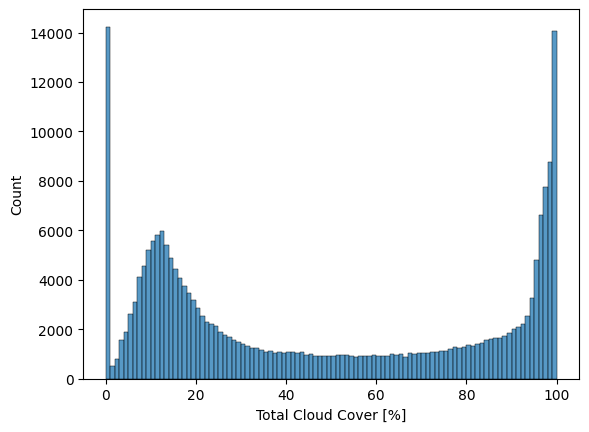

In [23]:
sns.histplot(train[(train['MST'] > 400) & (train['MST'] < 1080)]['Total Cloud Cover [%]'], bins = 100)

## Finding linear relation of cloud cover with other features

def make_plots(
    df : pd.DataFrame,
    target_feature : str,
    feature_pool : list[str],
    nrows, ncols, scale
):
    fig,ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (scale*ncols ,scale*nrows))
    ax = ax.flatten()
    max_len = min(ax.shape[0], len(feature_pool))
    for i in range(max_len):
        axes = ax[i]
        y,x = df[[target_feature,feature_pool[i]]].to_numpy().T
        axes.scatter(x,y, marker = '.')
        axes.set_ylabel(target_feature)
        axes.set_xlabel(feature_pool[i])
        axes.set_title(f'{target_feature} vs \n {feature_pool[i]}')
        
    fig.show()

feature_pool = ['MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)']
print(len(feature_pool))

required_df = train[(train['Total Cloud Cover [%]'] > 0) & (train['DATE (MM/DD)'] == '01/03')].reset_index()

make_plots(
    required_df,
    target_feature = 'Total Cloud Cover [%]',
    feature_pool = feature_pool[0:8],
    nrows = 2,
    ncols = 4,
    scale = 4
)

make_plots(
    required_df,
    target_feature = 'Total Cloud Cover [%]',
    feature_pool = feature_pool[8:],
    nrows = 2,
    ncols = 4,
    scale = 4
)

# Creating tensorflow datasets

## Sampling from within a day with non-zero Cloud Cover or within each day

In [24]:
# For Only non - Zero cloud cover
# non_zero_indices = train['Total Cloud Cover [%]'] > 0
# print(non_zero_indices.sum())
# # for whole day
non_zero_indices = np.full([train.to_numpy().shape[0]], True)
print(non_zero_indices.sum())

482400


In [25]:
train.to_numpy().shape

(482400, 17)

In [26]:
# train_y_df = lagged_columns

In [27]:
data_X = train_x_df[non_zero_indices]
data_y = train_y_df[non_zero_indices]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Total Cloud Cover [%]', ylabel='Count'>

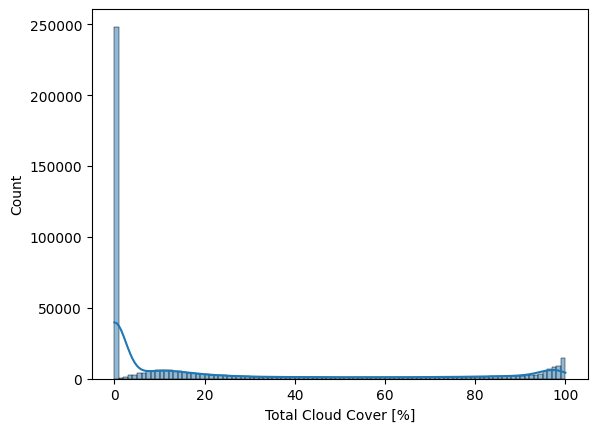

In [28]:
sns.histplot(train[non_zero_indices]['Total Cloud Cover [%]'],bins = 100, kde = True)

In [29]:
def get_sequences_of_listed_days(days_list, data_df,train_x_df, train_y_df, window_size = 360, future_buffer = 30):
        X_dataset_list = []
        y_dataset_list = []
        for day in days_list:
            day_x_df = train_x_df.loc[data_df['DATE (MM/DD)'] == day].to_numpy()
            day_y_df = train_y_df.loc[data_df['DATE (MM/DD)'] == day].to_numpy()
            data_len = day_x_df.shape[0]
            assert day_x_df.shape[0] == day_y_df.shape[0]
            day_x_df = day_x_df[0 : data_len - future_buffer]
#             day_y_df = day_y_df[window_size - 1:data_len - future_buffer]
            day_y_df = day_y_df[window_size:]
            X_dataset_list.append(get_dataset_of_sequences(day_x_df, window_size = window_size))
            y_dataset_list.append(get_dataset_of_sequences(day_y_df, window_size = future_buffer))
#             y_dataset_list.append(tf.data.Dataset.from_tensor_slices(day_y_df))
            
        
        X_dataset = X_dataset_list[0]
        y_dataset = y_dataset_list[0]
        for dataset in X_dataset_list[1:]:
            X_dataset = X_dataset.concatenate(dataset)
        for dataset in y_dataset_list[1:]:
            y_dataset = y_dataset.concatenate(dataset)
        return X_dataset, y_dataset
    

    
def get_dataset_of_sequences(X, window_size = 360, stride = 1, shift = 1):
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(window_size,shift = shift, stride = stride,drop_remainder = True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size))
    return dataset

def apply_dataset_optimizations(dataset,cache = False, batch_size = 32, shuffle = False, shuffle_size = 32):
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [30]:
gap = 2
future_buffer = 30 / gap # 30 minutes because sampling every minute
sequence_size = 360 / gap
print(future_buffer, sequence_size)
future_buffer,sequence_size = int(future_buffer),int(sequence_size)

15.0 180.0


In [31]:
X = data_X[::gap]
y = data_y[::gap]

In [32]:
assert len(X) == len(y)

In [33]:
print(len(X))

241200


In [34]:
days_list = train.iloc[:,0].unique()
days_list = sorted(days_list)
print(days_list[0:10])

['01/01', '01/02', '01/03', '01/04', '01/05', '01/06', '01/07', '01/08', '01/09', '01/10']


In [35]:
def get_datasets(X,y,days_list,train,window_size,future_buffer):
    dataset_val = tf.data.Dataset.zip(
        get_sequences_of_listed_days(
            days_list[-17:], 
            train, 
            X, 
            y, 
            window_size = window_size, 
            future_buffer = future_buffer)
    )
    dataset_train = tf.data.Dataset.zip(
        get_sequences_of_listed_days(
            days_list[-18::-1][::-1], 
            train, 
            X, 
            y,  
            window_size = window_size, 
            future_buffer = future_buffer)
    )

    print(dataset_val.as_numpy_iterator().next()[0].shape, dataset_val.as_numpy_iterator().next()[1].shape)
    print(dataset_train.as_numpy_iterator().next()[0].shape, dataset_train.as_numpy_iterator().next()[1].shape)
    return dataset_train, dataset_val

In [36]:
dataset_train, dataset_val = get_datasets(
    X = X,
    y = y,
    days_list = days_list,
    train = train,
    window_size = sequence_size,
    future_buffer = future_buffer
)

(180, 16) (15, 1)
(180, 16) (15, 1)


In [37]:
print(dataset_val.as_numpy_iterator().next()[0].shape, dataset_val.as_numpy_iterator().next()[1].shape)
print(dataset_train.as_numpy_iterator().next()[0].shape, dataset_train.as_numpy_iterator().next()[1].shape)

(180, 16) (15, 1)
(180, 16) (15, 1)


In [38]:
dataset_val = apply_dataset_optimizations(
    dataset_val,
    batch_size = 32, 
    cache = True
)
dataset_train = apply_dataset_optimizations(
    dataset_train,
    batch_size = 32, 
    cache = True
)

print(dataset_val.as_numpy_iterator().next()[0].shape, dataset_val.as_numpy_iterator().next()[1].shape)
print(dataset_train.as_numpy_iterator().next()[0].shape, dataset_train.as_numpy_iterator().next()[1].shape)

(32, 180, 16) (32, 15, 1)
(32, 180, 16) (32, 15, 1)


In [39]:
np.isnan(np.concatenate([data[1] for data in dataset_val.as_numpy_iterator()])).shape

(8942, 15, 1)

In [40]:
model = tf.keras.models.load_model('/kaggle/input/ccd-ai/keras/LSTM-series-B/5/LSTM_series_B_early_stopped.keras')

In [ ]:
model.compile(optimizer='adam',
loss=tf.keras.losses.MeanSquaredError(),
metrics=[
    tf.keras.metrics.R2Score(), 
#     r2_score_per_class,
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.RootMeanSquaredError(),
])


In [ ]:
model.evaluate(dataset_val, return_dict = True), 

# Saving Models to Kaggle Database

## Secret and Directory Initialization

In [ ]:
dir_to_new_model = '/kaggle/working/models'
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

os.makedirs('/kaggle/working/models', exist_ok = True)

## Creating Kaggle Models

In [ ]:


model_meta_data = {
  "ownerSlug": "ishansrivastava1308",
  "title": "CloudCover AI",
  "slug": "ccd-ai",
  "subtitle": "",
  "isPrivate": False,
  "description": "# Model Summary\n\n# Model Characteristics\n\n# Data Overview\n\n# Evaluation Results\n",
  "publishTime": "",
  "provenanceSources": ""
}

with open(os.path.join(dir_to_new_model,'model-metadata.json'), 'w') as f:
    json.dump(model_meta_data, f)
    

In [ ]:
#  !kaggle models create --path /kaggle/working/models

## Creating Model instance

In [ ]:
model_instance_meta_data = {
  "ownerSlug": "ishansrivastava1308",
  "modelSlug": "ccd-ai",
  "instanceSlug": "attention-seq-to-seq",
  "framework": "keras",
  "overview": "",
  "usage": "# Model Format\n\n# Training Data\n\n# Model Inputs\n\n# Model Outputs\n\n# Model Usage\n\n# Fine-tuning\n\n# Changelog\n",
  "licenseName": "Apache 2.0",
  "fineTunable": True,
  "trainingData": [],
  "modelInstanceType": "Unspecified",
  "baseModelInstanceId": 0,
  "externalBaseModelUrl": ""
}

with open(os.path.join('/kaggle/working/models','model-instance-metadata.json'), 'w') as f:
    json.dump(model_instance_meta_data, f)
    

In [ ]:
!kaggle models instances create -p /kaggle/working/models --dir-mode tar

## Creating model versions

In [ ]:
!kaggle models instances versions create ishansrivastava1308/ccd-ai/keras/attention-seq-to-seq -p /kaggle/working/models --dir-mode tar

# Metrics and Callbacks

## Callbacks

In [48]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            print()
            val = {}
            train = defaultdict(lambda: "None")
            for k,v in logs.items():
                if k.startswith('val_'):
                    val[k[4:]] = v
                else:
                    train[k] = [v, "None"]
            # print(val, train)

            for k,v in val.items():
                if train[k] != "None":
                    train[k][1] = v
                else:
                    train[k] = ["None", v]

            print("+","-"*42,"+","-"*42,"+","-"*42,"+",sep = "")
            print("| {:<40} | {:<40} | {:<40} |".format("Metrics","Train","Val"))
            print("+","-"*42,"+","-"*42,"+","-"*42,"+",sep = "")
            for k,v in train.items():
                print("| {:<40} | {:<40} | {:<40} |".format(k, v[0], v[1]))
            print("+","-"*128,"+",sep = "")
            print()



In [49]:
class SaveModelOnEpoch(tf.keras.callbacks.Callback):
    def __init__(self, save_path,freq = 5,offset = 0):
        super(SaveModelOnEpoch, self).__init__()
        self.save_path = save_path
        self.freq = freq
        self.offset = offset

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:  # Save every 5 epochs
            self.model.save(self.save_path.format(epoch=self.offset+epoch+1))
            print(f"Model saved at epoch {self.offset+epoch+1}.")
        
save_callback = SaveModelOnEpoch('/kaggle/working/models/Seq_to_seq_LSTM_{epoch}.keras',offset = 0, freq = 2)

In [50]:
class PlotPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val, start = 0, end = None):
        super(PlotPredictionsCallback, self).__init__()
        self.x_val = x_val
        self.y_val = y_val.flatten()
        self.start = start
        self.end = end

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x_val)
        
        pd.DataFrame(np.column_stack([
            y_pred.flatten()[start:end],
            self.y_val[start:end]
        ]), columns = ["Predictions", "Ground Truth"]).plot(figsize = (15,6), grid = True)
        
        

In [51]:
import tensorflow as tf
from datetime import datetime
model_dir  = '/kaggle/working/models'
log_dir = os.path.join(model_dir,"logs/fit/") + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
# !cp -r /kaggle/input/ccd-ai/keras/LSTM-series-B/4/logs /kaggle/working/models

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=2, verbose=1)

In [54]:
%load_ext tensorboard
%tensorboard --logdir {os.path.join(model_dir,"logs/fit/")}

In [55]:
!rm -rf /kaggle/working/logs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
# R2 Score Metric
import tensorflow as tf
from sklearn.metrics import r2_score

def r2_score_per_class(y_true, y_pred):
    print(y_true, y_pred)
    r2_per_class = []
    for i in range(y_true.shape[1]):  # Iterate over each class
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        r2_per_class.append(r2)
    return tf.convert_to_tensor(r2_per_class, dtype=tf.float32)

In [56]:
# R2 Score Metric
import tensorflow as tf
from sklearn.metrics import r2_score

def r2_score_flattened(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    _y_true = tf.keras.layers.Flatten()(y_true)
    _y_pred = tf.keras.layers.Flatten()(y_pred)
    r2 = tf.keras.metrics.R2Score()
    r2.update_state(_y_true, _y_pred)
    return tf.convert_to_tensor(r2.result(), dtype=tf.float32)

In [57]:
class BinaryTruePositives(Metric):

    def __init__(self, name='binary_true_positives', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='R2Score'
        )
        self.r2_obj = tf.keras.metrics.R2Score()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.reshape(y_true, newshape)
        y_pred = ops.cast(y_pred, "bool")

        values = ops.logical_and(
            ops.equal(y_true, True), ops.equal(y_pred, True))
        values = ops.cast(values, self.dtype)
        if sample_weight is not None:
            sample_weight = ops.cast(sample_weight, self.dtype)
            sample_weight = ops.broadcast_to(
                sample_weight, ops.shape(values)
            )
            values = ops.multiply(values, sample_weight)
        self.true_positives.assign(self.true_positives + ops.sum(values))

    def result(self):
        return self.true_positives

NameError: name 'Metric' is not defined

# LSTM Model


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((180,16)),
    tf.keras.layers.Conv1D(1024,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(512,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(256,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(256,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(128,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('linear'),
    
    tf.keras.layers.LSTM(256, return_sequences=True, ),
    tf.keras.layers.LSTM(128, return_sequences=False,),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'linear')
    
])

model.summary()

## Multi-LSTM

In [ ]:
n_past = 180
n_future = 15
n_features = 16
n_output_features = 1


inputs = tf.keras.layers.Input(shape=(n_past, n_features))

# Inference Model
# x = tf.keras.layers.Conv1D(1024,1)(inputs)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
# x = tf.keras.layers.Conv1D(512,1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv1D(512,1)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
# x = tf.keras.layers.Conv1D(256,1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv1D(256,1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv1D(128,1)(x)
x = tf.keras.layers.BatchNormalization()(x)
encoder_inputs = tf.keras.layers.Activation('linear')(x)



# Sequence Encoder
encoder_l1 = tf.keras.layers.LSTM(512,return_sequences = True, return_state=True,)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

# concatenate = tf.keras.layers.Concatenate()([encoder_outputs1[0],inputs,encoder_inputs])
# attention = tf.keras.layers.Attention()([concatenate, concatenate, concatenate])

encoder_l2 = tf.keras.layers.LSTM(512, return_state=True,)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(512, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(512, return_sequences=True)(decoder_l1, initial_state = encoder_states2)

# MLP to get outputs
# decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256))(decoder_l2)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_output_features))(x)
#


model = tf.keras.models.Model(inputs,decoder_outputs2)
#
model.summary()

## Seq to Seq with Attention

In [ ]:
n_past = 180
n_future = 15
n_features = 16
n_output_features = 1
inputs = tf.keras.layers.Input(shape=(n_past, n_features))

def attention_layer(inputs):
    inp = tf.keras.layers.Dense(128)(inputs)
    attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(inp, inp, inp)
    x = tf.keras.layers.Add()([inp, attention])
    norm_add = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Dense(128)(norm_add)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Add()([norm_add, x])
    x = tf.keras.layers.LayerNormalization()(x)
    return x

def make_model():
    inference_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128,1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv1D(64,1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv1D(32,1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('linear'),
    ], name = 'Inference_model')

#     encoder_inputs = inference_model(inputs)
    encoder_l1 = tf.keras.layers.LSTM(128,return_sequences = True, return_state=True)
    enc_seq1, enc_h1, enc_c1 = encoder_l1(inputs)

    # attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)
    # attention_output = attentioreturn_staten(*[enc_seq1, enc_seq1, enc_seq1])
    # We get a attention score for each of the layers


    attention = attention_layer(enc_seq1)
    attention = attention_layer(attention)
    attention = attention_layer(attention)
    context_vector = tf.keras.layers.Multiply()([attention,enc_seq1])


    decoder_hidden_states = [enc_h1, enc_c1]

    outputs = []
    for i in range(n_future):
        hidden_rep = tf.keras.layers.RepeatVector(180)(decoder_hidden_states[0])
        context_rep = tf.keras.layers.RepeatVector(180)(decoder_hidden_states[0])
        concatenation = tf.keras.layers.Concatenate(axis = -1)([context_vector, encoder_inputs, hidden_rep, context_rep])
        self_attention = tf.keras.layers.Conv1D(128,1)(concatenation)
        self_attention = tf.keras.layers.BatchNormalization()(self_attention)
        self_attention = tf.keras.layers.Activation('relu')(self_attention)
#         self_attention = tf.keras.layers.Conv1D(64,1)(self_attention)
#         self_attention = tf.keras.layers.BatchNormalization()(self_attention)
#         self_attention = tf.keras.layers.Activation('relu')(self_attention)
#         self_attention = tf.keras.layers.Conv1D(32,1)(self_attention)
#         self_attention = tf.keras.layers.BatchNormalization()(self_attention)
#         self_attention = tf.keras.layers.Activation('relu')(self_attention)
        self_attention = tf.keras.layers.Conv1D(1,1)(self_attention)
        self_attention = tf.keras.layers.BatchNormalization()(self_attention)
        self_attention = tf.keras.layers.Activation('linear')(self_attention)
        self_attention = tf.keras.layers.Flatten()(self_attention)
        cell_outputs, decoder_hidden_states = tf.keras.layers.LSTMCell(128)(self_attention,decoder_hidden_states)
        cell_outputs = tf.keras.layers.Reshape((1,128))(cell_outputs)
        outputs.append(cell_outputs)

        # Decoding

    concatenate_outputs = tf.keras.layers.Concatenate(axis = -2)(outputs)
    
    x = tf.keras.layers.Conv1D(256,1)(concatenate_outputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(256,1)(concatenate_outputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(1,1)(x)

    model = tf.keras.Model(inputs, x)
    return model

model = make_model()
model.summary()


## Encoder Decoder with attention

In [ ]:
n_past = 180
n_future = 15
n_features = 16
n_output_features = 1


def attention_layer(inputs):
    inp = tf.keras.layers.Dense(64)(inputs)
    attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(inp, inp, inp)
    x = tf.keras.layers.Add()([inp, attention])
    norm_add = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Dense(64)(norm_add)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Add()([norm_add, x])
    x = tf.keras.layers.LayerNormalization()(x)
    return x

def attention_layer_decoder(inputs, key, value):
    inp = tf.keras.layers.Dense(64)(inputs)
    attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(inp, key, value)
    x = tf.keras.layers.Add()([inp, attention])
    norm_add = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Dense(64)(norm_add)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Add()([norm_add, x])
    x = tf.keras.layers.LayerNormalization()(x)
    return x

def get_attention_sequence(inputs):
    encoder_l1 = tf.keras.layers.LSTM(64,return_sequences = True, return_state=True,)
    encoder_outputs1 = encoder_l1(inputs)
    attention_1 = attention_layer(encoder_outputs1[0])
    return attention_1, encoder_outputs1

def get_decoder_attention(inputs, key, value, hidden_states):
    encoder_l1 = tf.keras.layers.LSTM(64,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(inputs, initial_state = hidden_states)
    attention_1 = attention_layer_decoder(encoder_outputs1[0], key, value)
    return attention_1, encoder_outputs1


inputs = tf.keras.layers.Input(shape=(n_past, n_features))

# Sequence Encoder
attention_1, encoder_hidden_1 = get_attention_sequence(inputs)

attention_2, encoder_hidden_2 = get_attention_sequence(attention_1)

attention_3, encoder_hidden_3 = get_attention_sequence(attention_1)

# Compressor

compressor_outputs = tf.keras.layers.LSTM(1024, return_state = True)(attention_3)

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(compressor_outputs[0])

decoder_attention_1, _ = get_decoder_attention(decoder_inputs, attention_3, attention_3, encoder_hidden_3[1:])

decoder_attention_2, _ = get_decoder_attention(decoder_attention_1, attention_2, attention_2, encoder_hidden_2[1:])

decoder_attention_1, _ = get_decoder_attention(decoder_attention_2, attention_1, attention_1, encoder_hidden_3[1:])

x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256))(decoder_attention_1)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_output_features))(x)
#


model = tf.keras.models.Model(inputs,decoder_outputs2)
#
model.summary()

# Model Training

In [42]:
model = tf.keras.models.load_model('/kaggle/input/ccd-ai/keras/attention-seq-to-seq/1/Seq_to_seq_LSTM_10.keras', compile = False)

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 180, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ [(None, 180, 64), │     20,736 │ input_layer_4[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 180, 64)   │      4,160 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 64)   │    132,672 │ dense_49[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_49[0][0],   │
│                     │                   │            │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 180, 64)   │          0 │ dense_49[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 180, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 180, 64)   │          0 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 180, 64)   │      4,160 │ re_lu_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 180, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ [(None, 180, 64), │     33,024 │ layer_normalizat… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 180, 64)   │      4,160 │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 64)   │    132,672 │ dense_55[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_55[0][0],   │
│                     │                   │            │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 180, 64)   │          0 │ dense_55[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 180, 64)   │        128 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 180, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,782,529 (22.06 MB)

 Trainable params: 5,782,017 (22.06 MB)

 Non-trainable params: 512 (2.00 KB)

In [41]:
x_val = tf.convert_to_tensor(np.concatenate([data[0] for data in dataset_train]))
y_val = tf.convert_to_tensor(np.concatenate([data[1] for data in dataset_train]))

In [45]:
print(x_val.shape, y_val.shape)

(167268, 180, 16) (167268, 15, 1)


In [58]:
!cp -r /kaggle/input/ccd-ai/keras/attention-seq-to-seq/1/logs /kaggle/working/models

In [59]:
model.compile(optimizer='adam',
loss=tf.keras.losses.MeanSquaredError(),
metrics=[
#     tf.keras.metrics.R2Score(), 
#     r2_score_per_class,
#     r2_score_flattened,
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.RootMeanSquaredError(),
])


In [ ]:
history = model.fit(
    x = x_val,
    y = y_val,
    validation_data = dataset_val,
    initial_epoch = 10,
    epochs = 100,
    callbacks = [
        LossAndErrorPrintingCallback(), 
#         PlotPredictionsCallback(x_val[::15],y_val[::15])
        early_stopping, 
        save_callback, 
        tensorboard_callback
    ],
)

Epoch 11/100
5228/5228 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0405 - mean_absolute_error: 0.1125 - mean_absolute_percentage_error: 47.8908 - root_mean_squared_error: 0.2013

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



+------------------------------------------+------------------------------------------+------------------------------------------+
| Metrics                                  | Train                                    | Val                                      |
+------------------------------------------+------------------------------------------+------------------------------------------+
| loss                                     | 0.040218062698841095                     | 0.056573811918497086                     |
| mean_absolute_error                      | 0.11233770847320557                      | 0.0780419409275055                       |
| mean_absolute_percentage_error           | 47.754642486572266                       | 32.148223876953125                       |
| root_mean_squared_error                  | 0.20054441690444946                      | 0.23785251379013062                      |
+---------------------------------------------------------------------------------

In [ ]:
model.save('/kaggle/working/models/Attention_LSTM_session_1.keras')

In [ ]:
!kaggle models instances versions create ishansrivastava1308/ccd-ai/keras/LSTM-series-B -p /kaggle/working/models --dir-mode tar

In [ ]:
# with strategy.scope():
model = tf.keras.models.load_model('/kaggle/input/ccd-ai/keras/attention-seq-to-seq/1/Seq_to_seq_LSTM_10.keras', compile = False)

# Plotting and Evalutation

In [ ]:
# fig,ax = plt.subplots(figsize = (15,5))
# ax.plot(np.concatenate([batch1x[2,:,-1]]))

def plot_forecast(x,y,idx):
    batch1x = x[idx:idx+15]
    batch1y = y[idx:idx+15]
    pred = model.predict(batch1x)
    print(pred)

    pred_df = pd.DataFrame(np.full((195,3),np.nan), columns = ["Historical","Preds","Actual"])
    pred_df.loc[180:,["Preds","Actual"]] = np.column_stack([scalery.inverse_transform(pred[:]),scalery.inverse_transform(batch1y[:])])
    pred_df.loc[:179,["Historical"]] = scalery.inverse_transform(batch1x[0,:,-1].reshape(-1,1)),

    pred_df.plot(figsize = (16,5))

# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

In [ ]:
# fig,ax = plt.subplots(figsize = (15,5))
# ax.plot(np.concatenate([batch1x[2,:,-1]]))
x_val,y_true = dataset_val.as_numpy_iterator().next()
def plotter(x,y_true,y_pred):
    pred_df = pd.DataFrame(np.full((195,3),np.nan), columns = ["Historical","Preds","Actual"])
    pred_df.loc[180:,["Preds","Actual"]] = np.column_stack([scalery.inverse_transform(y_pred.reshape(-1)),scalery.inverse_transform(y_true)])
    pred_df.loc[:179,["Historical"]] = scalery.inverse_transform(x[:,-1].reshape(-1,1)),

    pred_df.plot(figsize = (16,5))

def plot_decoder_forecast(x,y):
    pred = model.predict(x.reshape(1,180,16))
    print(pred.shape)
    # shape = (batchsize, 15, 1)
    

# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

In [ ]:
dataset_val

In [ ]:
x_true = np.concatenate([data[0] for data in dataset_val])
y_true = np.concatenate([data[1] for data in dataset_val])

In [ ]:
series_predictions = model.predict(x_true[::15])

In [ ]:
r2 = tf.keras.metrics.R2Score()
r2.update_state(series_predictions.reshape(-1,1),y_true[::15].reshape(-1,1))
r2.result()

In [ ]:
series_predictions.shape

In [ ]:

class ComparisonPlotter:
    def __init__(self):
        pass
    def plot_dataframe(self,start = 0, end = None):
        self._df.loc[start:end].plot(figsize = (16,6), grid = True)
        start,end = 500,1700
        
    def set_df_from_columns(
        self,
        columns_list,
        columns = None
    ):
        self._df = pd.DataFrame(np.column_stack(columns_list), columns = columns) 
        

        

In [ ]:
plotter = ComparisonPlotter()
plotter.set_df_from_columns(
    [
        scalery.inverse_transform(series_predictions.reshape(-1,1)),
        scalery.inverse_transform(y_true[::15].reshape(-1,1))
    ],
    columns = ["Predictions", "True"]
)

In [ ]:
plotter.plot_dataframe(8800)

In [ ]:

start,end = 0,None
pd.DataFrame(np.column_stack([
    series_predictions[start:end][:,1],
    y_true[start:end][:,1]
])).plot(figsize = (15,6), grid = True)

In [ ]:
idx = 260
plot_decoder_forecast(x_val[idx], y_true[idx])

In [ ]:
scalery.inverse_transform(model.predict(X_train[0]))

In [ ]:
predictions = model.predict(dataset_val)

In [ ]:
y_val = np.concatenate([data[1] for data in dataset_val])

In [ ]:
pd.DataFrame(np.column_stack([scalery.inverse_transform(predictions), scalery.inverse_transform(y_val)]), columns = ['Preds', 'True'])[500:1000].plot(figsize = (15,5))